# Where To Live in Hawaii?

## House prices, and local venue analysis of the Hawaiian Islands

## a. Introduction

Hawaii, USA is known globally as tropical vacation islands. However closer to home it’s reputation is known for being extremely expensive to live in. Out of 51 states (including District of Columbia) Hawaii is [ranked](http://worldpopulationreview.com/states/cost-of-living-index-by-state/) 51 for highest cost of living. Hawaii’s median house value is almost triple the national average at \\$619,000. One thing that Hawaii ranks low in is land size. In the US it is the fourth smallest state. 

Many people think Hawaii would be a great state to live in, and they are probably right. But with such high costs one wants to know the exact island they wish to move to before taking the plunge. Hawaii is comprised of over 130 islands, however this analysis will look deeper into the main 6 of them. 

This report will answer the question of what Hawaiian island is the best to move to in terms of house prices and nearby venues. Investors as well as people wishing to move to Hawaii are my main stakeholders in the analysis. It will demonstrate which island has room to grow, and which one if any has seen its day.


## b. Data

The data I have aquired to solve the problem:

 1. Zip codes and cities of Hawaii
 2. Median house price for the different cities 
 3. Longitude and latitude of the various Hawaiian cities
 4. Venue data 


In [1]:
#from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import types


In [ ]:
import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

### 1. Zip codes and cities

I have used this [website](https://www.zipcodestogo.com/Hawaii/) that listed all of the zip codes with the name of the city. Then extracted the data off of the website using BeautifulSoup

In [5]:
url = 'https://www.zipcodestogo.com/Hawaii/'


In [7]:
response = requests.get(url, headers = headers)

In [8]:
# Check it was correctly connected to the website
response.status_code

200

In [ ]:
soup = BeautifulSoup(response.content, 'html.parser')
zips = soup.find_all('table', class_ ='inner_table')

In [ ]:
hi_zip = zips[0]

In [ ]:
# This is loop through all columns and cells and add it to the dataframe
l = []
table_rows = hi_zip.find_all('tr')

for tr in table_rows:
    td = tr.find_all('td')
    row = [tr.text.strip() for tr in td if tr.text.strip()]
    if row:
        l.append(row)
    
df = pd.DataFrame(l, columns=["Zip Code", "City", "County", "Drop"])

In [ ]:
df.head()

I have grabbed everything from the table, but will clean it up to just get the data I will need

In [ ]:
df.drop(columns='Drop', inplace=True)

In [ ]:
df.drop([0,1], inplace=True)

In [ ]:
df.shape

In [ ]:
df.head()

### 2. Median House Prices

I used [Zilllow](https://www.zillow.com/kilauea-hi-96703/home-values/) to create my own dataset with the previous scraped zip codes and cities. I collected the median home value. A lot of the zip codes provided didn't have housing data because of two reasons. 1. The zip code was covering national park area and did not have housing data. 2. The zip code of close neighboring cities were recongized by one zip code.

In Excel I removed duplicate cities that were missing house price data.

In [3]:
path = 'hawaii_no_dups.csv'
hawaii_house = pd.read_csv(path)
hawaii_house.head()


,Zip Code,city,County,House Price
0,96701,Aiea,Honolulu,704300.0
1,96703,Anahola,Kauai,590300.0
2,96861,Camp H M Smith,Honolulu,NaN
3,96704,Captain Cook,Hawaii,363800.0
4,96705,Eleele,Kauai,495600.0


### 3. Longitude and Latitude

I obtained this data [online](https://simplemaps.com/data/us-cities). It was downloaded as an Excel file. It contained the coordinates for all 50 states. I filtered out all but Hawaii and uploaded the data.  

In [4]:
path = 'lat long hi new.csv'
lat_long = pd.read_csv(path)
lat_long.head()

,city,county_name_all,lat,lng
0,Paauilo,Hawaii,20.0397,-155.3696
1,Discovery Harbour,Hawaii,19.0415,-155.6254
2,Haena,Kauai,22.2186,-159.5610
3,Ualapue,Maui,21.0704,-156.8355
4,Waikane,Honolulu,21.4921,-157.8721


In [5]:
#Merge the two datasets 
hawaii = pd.merge(hawaii_house, lat_long, on = 'city', how='outer')

In [6]:
hawaii.head()

,Zip Code,city,County,House Price,county_name_all,lat,lng
0,96701.0,Aiea,Honolulu,704300.0,Honolulu,21.3865,-157.9232
1,96703.0,Anahola,Kauai,590300.0,Kauai,22.1455,-159.3151
2,96861.0,Camp H M Smith,Honolulu,NaN,NaN,NaN,NaN
3,96704.0,Captain Cook,Hawaii,363800.0,Hawaii,19.4995,-155.8937
4,96705.0,Eleele,Kauai,495600.0,Kauai,21.9088,-159.5801


In [7]:
hawaii.shape

(178, 7)

This dataframe needs to be cleaned up a bit. As house price and lat/long are the most important columns for the analysis. I will pull out only those with both pieces of data.

In [8]:
hawaii_na = hawaii[hawaii['House Price'].notnull() & hawaii['lat'].notnull()].reset_index(drop=True)

The data set is now left with 48 cities 

In [16]:
hawaii_na.shape

(48, 7)

In [13]:
hawaii_df = hawaii_na.drop(columns=['county_name_all', 'Zip Code'])
hawaii_df.rename(columns={'city': 'City', 'lat': 'Latitude', 'lng': 'Longitude'}, inplace=True)

In [14]:
hawaii_df.head()

,City,County,House Price,Latitude,Longitude
0,Aiea,Honolulu,704300.0,21.3865,-157.9232
1,Anahola,Kauai,590300.0,22.1455,-159.3151
2,Captain Cook,Hawaii,363800.0,19.4995,-155.8937
3,Eleele,Kauai,495600.0,21.9088,-159.5801
4,Ewa Beach,Honolulu,625100.0,21.3181,-158.0073


In [17]:
hawaii_df.at[12, 'Latitude'] = 21.2700
hawaii_df.at[12, 'Longitude'] = -157.8182

### 4. Venue Data

For the venue data I accessed Foursquare API. I chose a radius of 1.5km and a limit of 100 venues. I decided to increase the radius because when using only 500m there was not a city with more than 25 venues. When looking at the city plots on the map it is clear that a lot of the areas have a large distance between them. This makes sense why a 500m radius turned up very little. Even still with 1.5km there are a handful of cities with less than 2 venues. I'm interested to see if these cities are correlated to lower priced houses.

In [19]:
def getNearbyVenues(names, latitudes, longitudes, radius=1500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [21]:
venue = getNearbyVenues(names= hawaii_df['City'],
                                   latitudes=hawaii_df['Latitude'],
                                   longitudes=hawaii_df['Longitude']
                                  )

Aiea
Anahola
Captain Cook
Eleele
Ewa Beach
Haleiwa
Hanalei
Hanapepe
Hauula
Hilo
Holualoa
Honokaa
Honolulu
Kaaawa
Kahului
Kailua
Kalaheo
Kaneohe
Kapaa
Kapaau
Kapolei
Kaunakakai
Kealakekua
Kekaha
Kihei
Kilauea
Koloa
Kula
Kurtistown
Lahaina
Laie
Lanai City
Lihue
Makawao
Mountain View
Naalehu
Pahoa
Paia
Pearl City
Princeville
Volcano
Wahiawa
Waialua
Waianae
Wailuku
Waimanalo
Waimea
Waipahu


In [18]:
venue.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Aiea,21.3865,-157.9232,The Alley Restaurant,21.379108,-157.929550,Japanese Restaurant
1,Aiea,21.3865,-157.9232,Aiea Bowl,21.379102,-157.929651,Bowling Alley
2,Aiea,21.3865,-157.9232,Ice Garden,21.378890,-157.929873,Ice Cream Shop
3,Aiea,21.3865,-157.9232,Pearl Country Club,21.392433,-157.935925,Golf Course
4,Aiea,21.3865,-157.9232,Palazzo Italian Ristorante,21.379343,-157.931611,Italian Restaurant


In [25]:
print("Total number of venues for the 48 cities: ", len(venue))
print("Total number of cities ", venue['Neighborhood'].nunique())

Total number of venues for the 48 cities:  1277
Total number of cities  46


It looks 2 cities did not retrieve any venues, I will create a data frame with the venue counts for each city


In [68]:
# This will create a new dataframe that contains the venue count for each city.
data = venue.groupby('Neighborhood')['Venue'].count()
pd.DataFrame(data)


house_venue_count = pd.merge(hawaii_df, data, on = 'Neighborhood')
house_venue_count.tail()

,Neighborhood,County,House Price,Latitude,Longitude,Venue
41,Waianae,Honolulu,422700.0,21.4569,-158.1759,3
42,Wailuku,Maui,576300.0,20.8834,-156.5059,38
43,Waimanalo,Honolulu,742700.0,21.3421,-157.7303,21
44,Waimea,Kauai,451900.0,20.0124,-155.6378,1
45,Waipahu,Honolulu,667000.0,21.3858,-158.0103,47


In [30]:
# one hot encoding, so it can be sorted
onehot = pd.get_dummies(venue[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
onehot['Neighborhood'] = venue['Neighborhood'] 

# Moving Neighborhood to first column
cols = list(onehot)
cols.insert(0, cols.pop(cols.index('Neighborhood')))
cols

onehot = onehot.loc[:, cols]
onehot.head()

onehot.head()

,Neighborhood,ATM,Accessories Store,Airport,Airport Service,American Restaurant,Aquarium,Arcade,Art Gallery,Arts & Crafts Store,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,Aiea,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Aiea,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Aiea,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Aiea,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Aiea,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
hawaii_grouped = onehot.groupby('Neighborhood').mean().reset_index()
hawaii_grouped.head()

,Neighborhood,ATM,Accessories Store,Airport,Airport Service,American Restaurant,Aquarium,Arcade,Art Gallery,Arts & Crafts Store,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,Aiea,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.025,0.0,0.0,0.0
1,Anahola,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0
2,Captain Cook,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0
3,Eleele,0.0,0.019231,0.0,0.0,0.019231,0.0,0.0,0.038462,0.076923,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0
4,Ewa Beach,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0


In [32]:
# This function will sort by the number amount, and return the specified venue category amound of venue
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    df = row_categories_sorted[0:num_top_venues].to_frame()
    df2 = df.reset_index()
    df2.columns=['category', 'amount']
    i = 0
    while i < num_top_venues:
        if df2['amount'].iloc[i] == 0.0:
            df2['category'].iloc[i] = 'None'
        i+=1
            
   
    return df2['category'].values[0:num_top_venues]

In [33]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = hawaii_grouped['Neighborhood']


for ind in np.arange(hawaii_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(hawaii_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Aiea,Convenience Store,Fast Food Restaurant,Mexican Restaurant,Food Truck,Park
1,Anahola,Café,Spa,Burger Joint,Gift Shop,Beach
2,Captain Cook,Bookstore,Bed & Breakfast,Farm,Lawyer,Thrift / Vintage Store
3,Eleele,Dessert Shop,Boat or Ferry,Arts & Crafts Store,Gift Shop,Bakery
4,Ewa Beach,Fast Food Restaurant,Pizza Place,Home Service,Sandwich Place,Noodle House
5,Haleiwa,Food Truck,Ice Cream Shop,Surf Spot,Boutique,Board Shop
6,Hanalei,Beach,Food Truck,Seafood Restaurant,BBQ Joint,Pizza Place
7,Hanapepe,Boat or Ferry,Bakery,Arts & Crafts Store,Shopping Plaza,Bookstore
8,Hauula,Trail,Food,Surf Spot,Pharmacy,Grocery Store
9,Hilo,Convenience Store,Video Store,Planetarium,Asian Restaurant,None



This lists out all of the cities and the top 5 nearby venues according to category. Notice index 10 - Holualoa, it only has 1 nearby venue, so I have inserted None as a place holder. 


In [59]:
hawaii_df.rename(columns= {'City': 'Neighborhood'}, inplace= True)
hawaii_df_merge = hawaii_df

# merge hawaii_grouped with hawaii_df to add latitude/longitude and top 5 venues for each neighborhood
hawaii_df_merge = hawaii_df_merge.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

hawaii_df_merge.head()

,Neighborhood,County,House Price,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Aiea,Honolulu,704300.0,21.3865,-157.9232,Convenience Store,Fast Food Restaurant,Mexican Restaurant,Food Truck,Park
1,Anahola,Kauai,590300.0,22.1455,-159.3151,Café,Spa,Burger Joint,Gift Shop,Beach
2,Captain Cook,Hawaii,363800.0,19.4995,-155.8937,Bookstore,Bed & Breakfast,Farm,Lawyer,Thrift / Vintage Store
3,Eleele,Kauai,495600.0,21.9088,-159.5801,Dessert Shop,Boat or Ferry,Arts & Crafts Store,Gift Shop,Bakery
4,Ewa Beach,Honolulu,625100.0,21.3181,-158.0073,Fast Food Restaurant,Pizza Place,Home Service,Sandwich Place,Noodle House


In [62]:
no = hawaii_df_merge.dropna()
print("Number of unique 1st most common venue: " , no["1st Most Common Venue"].nunique())
print("Number of unique 2nd most common venue: " , no["2nd Most Common Venue"].nunique())
print("Number of unique 3rd most common venue: " , no["3rd Most Common Venue"].nunique())
print("Number of unique 4th most common venue: " , no["4th Most Common Venue"].nunique())
print("Number of unique 5th most common venue: " , no["5th Most Common Venue"].nunique())

Number of unique 1st most common venue:  32
Number of unique 2nd most common venue:  33
Number of unique 3rd most common venue:  35
Number of unique 4th most common venue:  31
Number of unique 5th most common venue:  32


### House Price Map 

Using Folium I created a map of Hawaii. The markers on the map are as follows:  
Green: \\$180,000 - \\$520,000\
Yellow: \\$520,000 - $864,000   
Red: \\$864,000+

In [34]:
house_min = hawaii_df['House Price'].min()
house_max = hawaii_df['House Price'].max()
house_mean = hawaii_df['House Price'].mean()

print("The median house price over the state of Hawaii: ",house_mean)

The median house price over the state of Hawaii:  609791.6666666666


In [35]:
breakp = np.linspace(house_min, house_max, num = 4, endpoint=True)
breakp

array([ 179600.        ,  521933.33333333,  864266.66666667,
       1206600.        ])

In [36]:
#Creates 4 equal bins. Instead of using low, medium, high I used the marker color so I could use it directly when creating the map
colBin = pd.cut(hawaii_df['House Price'], bins = breakp, labels = ['Green', 'Yellow', 'Red'], include_lowest=True)


In [37]:
df_marker_color = hawaii_df.merge(colBin.to_frame(), left_index=True, right_index=True)
df_marker_color.rename(columns={'House Price_y': 'Marker'}, inplace=True)

Most of the houses fall in the middle range

In [44]:
df_marker_color['Marker'].value_counts()

Yellow    23
Green     18
Red        7
Name: Marker, dtype: int64

In [43]:
df_marker_color.head()

,City,County,House Price_x,Latitude,Longitude,Marker
0,Aiea,Honolulu,704300.0,21.3865,-157.9232,Yellow
1,Anahola,Kauai,590300.0,22.1455,-159.3151,Yellow
2,Captain Cook,Hawaii,363800.0,19.4995,-155.8937,Green
3,Eleele,Kauai,495600.0,21.9088,-159.5801,Green
4,Ewa Beach,Honolulu,625100.0,21.3181,-158.0073,Yellow


In [45]:
address = 'Hawaii, USA'

geolocator = Nominatim(user_agent="hi_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of Hawaii are {}, {}.'.format(latitude, longitude))

The geographical coordinate of Hawaii are 21.2160437, -157.975203.


In [47]:
map_hawaii_house = folium.Map(location=[latitude, longitude], zoom_start=10)


for lat, lng, city, county, color in zip(df_marker_color['Latitude'], df_marker_color['Longitude'], df_marker_color['City'], df_marker_color['County'], df_marker_color['Marker']):
    label = '{}, {}'.format(city, county)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color = color,
        fill=True,
        fill_color= color,
        fill_opacity=0.7,
        parse_html=False).add_to(map_hawaii_house)  

    


map_hawaii_house

### Venue Map

I did the same thing with nearby venues. This would give me an overview of each island

In [48]:
minimum = house_venue_count['Venue'].min()
maximum = house_venue_count['Venue'].max()
breakp2 = np.linspace(minimum, maximum, num = 4, endpoint=True)
breakp2

array([  1.,  34.,  67., 100.])

In [55]:
colBin_venue = pd.cut(house_venue_count['Venue'], bins = breakp2, labels = ['Green', 'Yellow', 'Red'], include_lowest=True)

df_marker_color_venue = house_venue_count.merge(colBin_venue.to_frame(), left_index=True, right_index=True)
df_marker_color_venue.rename(columns={'Venue_x': 'Venue Count', 'Venue_y': 'Marker'}, inplace=True)
df_marker_color_venue.head()

,City,County,House Price,Latitude,Longitude,Venue Count,Marker
0,Aiea,Honolulu,704300.0,21.3865,-157.9232,40,Yellow
1,Anahola,Kauai,590300.0,22.1455,-159.3151,6,Green
2,Captain Cook,Hawaii,363800.0,19.4995,-155.8937,5,Green
3,Eleele,Kauai,495600.0,21.9088,-159.5801,52,Yellow
4,Ewa Beach,Honolulu,625100.0,21.3181,-158.0073,23,Green


This shows that there is a lot of areas with less than 34 nearby venues in a 1.5km radius.  
Also very few areas are overly congested

In [63]:
df_marker_color_venue['Marker'].value_counts()

Green     31
Yellow    11
Red        4
Name: Marker, dtype: int64

In [57]:
map_hawaii_venue = folium.Map(location=[latitude, longitude], zoom_start=10)


for lat, lng, city, county, color in zip(df_marker_color_venue['Latitude'], df_marker_color_venue['Longitude'], df_marker_color_venue['City'], df_marker_color_venue['County'], df_marker_color_venue['Marker']):
    label = '{}, {}'.format(city, county)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color = color,
        fill=True,
        fill_color= color,
        fill_opacity=0.7,
        parse_html=False).add_to(map_hawaii_venue)  

    


map_hawaii_venue

### House price and venue data correlation

I was interested to see if there was much correlation between high house price and high nearby venues.  
It's not strongly correlated, but there is something there

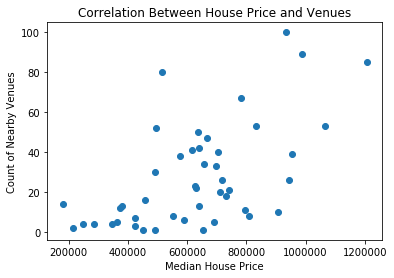

In [30]:
plt.scatter(house_venue_count['House Price'], house_venue_count['Venue'])
plt.xlabel("Median House Price")
plt.ylabel("Count of Nearby Venues")
plt.title("Correlation Between House Price and Venues")
plt.show()

In [31]:
np.corrcoef(house_venue_count['House Price'], house_venue_count['Venue'])

array([[1.        , 0.58724414],
       [0.58724414, 1.        ]])

### Conclusion


"Best" is an arbitrary term, because what one person thinks would be a perfect place to live could be the complete opposite. So here is what the analysis did uncover. 

- The island of Hawaii (The big island) has the most affordable houses. It also offers the least amount of nearby venues. 
- Oahu is the busiest. It offers the most venues, the most zip codes, and the highest house prices
- Kauai looks like it still has some areas of affordable houses while still offering a smaller island feel
- Maui has slightly more expensive housing than Kauai 
- Molokai and Lanai are both pretty small and with only 1 data point it is difficult to make an assumption about them